In [1]:
from sentenceSegmentation import SentenceSegmentation
from tokenization import Tokenization
from inflectionReduction import InflectionReduction
from stopwordRemoval import StopwordRemoval
from informationRetrieval import InformationRetrieval
from evaluation import Evaluation



from util import build_word_index

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score

# For additional corpus
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader import wordnet

# For hypothesis testing
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

from sys import version_info
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
def tfidf(docs, doc_ids, word_map, normalize = True, is_queries= False):
    
    m = len(set(word_map)); n = len(doc_ids); termfeq = np.zeros((m,n)) 
    #__________________________________________________________________
    for i in range(n):
        for sentence in docs[i]:
            for word in sentence:
                try:
                    termfeq[word_map[word]][doc_ids[i]-1] += 1
                except:
                    pass
    #__________________________________________________________________
    
    inverse_document_freq = termfeq!=0
    inverse_document_freq = np.sum(inverse_document_freq, axis = 1)
    inverse_document_freq = np.log10(n/inverse_document_freq).reshape(-1,1)
    tfidf = inverse_document_freq*termfeq
    if(is_queries):
        tfidf = termfeq
    if (normalize):
        epsilon = 1e-3
        return tfidf/ (np.linalg.norm(tfidf, axis = 0)+epsilon)
    
    return tfidf

In [3]:
from evaluation import Evaluation
import matplotlib.pyplot as plt

evalu = Evaluation()

def Eval_metric(doc_IDs_ordered, query_ids, qrels, no_components, plot_graph = 2, verbose = 1, title_name = " "):

    precisionset=[]
    recallset=[]
    fscoreset=[]
    MAPset=[]
    nDCGset = []
    for k in range(1,11):
        
        precision = evalu.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
        precisionset.append(precision)
        #________________________________________________________________________
        recall = evalu.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
        recallset.append(recall)
        #________________________________________________________________________
        fscore = evalu.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
        fscoreset.append(fscore)
        #________________________________________________________________________
        MAP = evalu.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
        MAPset.append(MAP)
        #_________________________________________________________________________
        nDCG = evalu.meanNDCG(doc_IDs_ordered, query_ids, qrels, k)
        nDCGset.append(nDCG)
        #_________________________________________________________________________
        if (verbose):
            print("Precision, Recall, F-score, MAP, nDCG at " +str(k) + " : " + str(precision) + ", " + str(recall) +  ", " + str(fscore)+", "+ str(MAP) +", " + str(nDCG))
            print("_________________________________________________________________________________________________________________________________________________________")
    #____________________________________________
    if (plot_graph == 1):
        plt.figure(figsize=(10,5))
        plt.plot(range(1, 11), precisionset, label="Precision",color='blue');plt.plot(range(1, 11), recallset, label="Recall",color='green')
        plt.plot(range(1, 11), fscoreset, label="F-Score",color='cyan');plt.plot(range(1, 11), MAPset, label="MAP",color='red')
        plt.plot(range(1, 11), nDCGset, label="nDCG",color='purple')
        plt.legend()
        plt.title(title_name)
        plt.xlabel("k")
    #________________________________________________

    return

In [4]:
def trial_run(qrels, doc_IDs_ordered, queries, k, model_name = ' ', bin_size = 20):

    dataframe = pd.DataFrame(qrels)
    eval_inst = Evaluation()

    #______________________________________________________________________
    precision_oneset = []
    precision_nillset = []
    recall_oneset = []
    recall_nillset = []

    #_______________________________________________________________________
    query_precision = []
    query_recall = []
    query_fscore = []
    #_______________________________________________________________________

    for i in range(len(doc_IDs_ordered)):
        #____________________________________________________________________________
        true_doc_ids = list(map(int, dataframe[dataframe['query_num'] == str(i+1)]['id'].tolist()))
        precision = eval_inst.queryPrecision(doc_IDs_ordered[i], i+1, true_doc_ids, k)
        query_precision.append(precision)
        recall = eval_inst.queryRecall(doc_IDs_ordered[i], i+1, true_doc_ids, k)
        query_recall.append(recall)
        fscore = eval_inst.queryFscore(doc_IDs_ordered[i], i+1, true_doc_ids, k)
        query_fscore.append(fscore)
        #_______________________________________________________________________

        if precision == 1:
            precision_oneset.append({'queryid':i+1, 'query': queries[i],'rel_docs':true_doc_ids, 'ret_docs':doc_IDs_ordered[i][:10]})
        elif precision == 0:
            precision_nillset.append({'queryid':i+1, 'query': queries[i],'rel_docs':true_doc_ids, 'ret_docs':doc_IDs_ordered[i][:10]})
            
        if recall == 1:
            recall_oneset.append({'queryid':i+1, 'query': queries[i],'rel_docs':true_doc_ids, 'ret_docs':doc_IDs_ordered[i][:10]})
        elif recall == 0:
            recall_nillset.append({'queryid':i+1, 'query': queries[i],'rel_docs':true_doc_ids, 'ret_docs':doc_IDs_ordered[i][:10]})

    #___________________________________________________________ ndcg for each query calculation
    query_ndcg = []
    for i in range(len(doc_IDs_ordered)):
        true_doc_ndcg = dataframe[dataframe['query_num'] == str(i+1)][['position', 'id']]
        ndcg = eval_inst.queryNDCG(doc_IDs_ordered[i], i+1, true_doc_ndcg, k)
        query_ndcg.append(list(ndcg)[0])

    return query_precision, query_recall, query_fscore, query_ndcg

<u><b>Import Data
 

In [5]:
#_____________________________________________________________________________________________________________
queries_set = json.load(open( ".\cranfield\cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_set], [item["query"] for item in queries_set]
#_____________________________________________________________________________________________________________
docs_set = json.load(open(".\cranfield\cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_set], [item["body"] for item in docs_set]
#_____________________________________________________________________________________________________________
Prequeries_processed = json.load(open('.\output\stopword_removed_queries.txt', 'r'))
#_____________________________________________________________________________________________________________
docs_processed = json.load(open('.\output\stopword_removed_docs.txt', 'r'))
#_____________________________________________________________________________________________________________
qrels = json.load(open( "./cranfield/cran_qrels.json", 'r'))[:]

 <u><b>Vector space Model

 Building word map:-
Word mapping to an index, which uniquely identifies the word

In [6]:
# Word is mapped to integer. Index(value) is identitier 
word_map = build_word_index(docs_processed, doc_ids)
tf_idf_docs_vector_space = tfidf(docs_processed, doc_ids, word_map, normalize = True)
vec_rep_queries_vector_space = tfidf(Prequeries_processed, query_ids, word_map, normalize = True, is_queries= True)

<b>Ranking and Evaluation

In [7]:

cosine_sim_vector_space = np.matmul(tf_idf_docs_vector_space.T, vec_rep_queries_vector_space)
doc_IDs_ordered_vector_space = (np.argsort(cosine_sim_vector_space,axis=0)+1)[::-1].T.tolist()

Precision, Recall, F-score, MAP, nDCG at 1 : 0.68, 0.11647913569164403, 0.1908304076887479, 0.68, 0.511111111111111
_________________________________________________________________________________________________________________________________________________________
Precision, Recall, F-score, MAP, nDCG at 2 : 0.5622222222222222, 0.1812293149634134, 0.2569470791720116, 0.7244444444444444, 0.4061050614447133
_________________________________________________________________________________________________________________________________________________________
Precision, Recall, F-score, MAP, nDCG at 3 : 0.5022222222222222, 0.2348383185004872, 0.29753819258734426, 0.7337037037037039, 0.38434465793015116
_________________________________________________________________________________________________________________________________________________________
Precision, Recall, F-score, MAP, nDCG at 4 : 0.4477777777777778, 0.2721078091301643, 0.31255271247264155, 0.7276543209876539, 0.3801

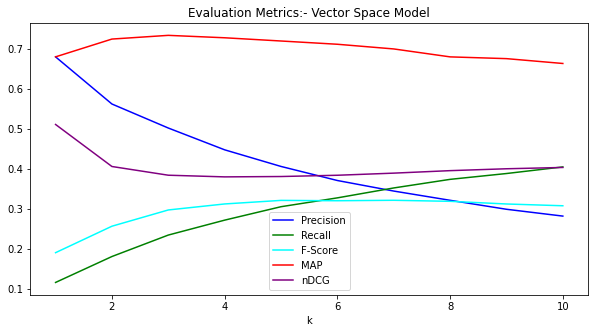

In [8]:
Eval_metric(doc_IDs_ordered_vector_space, query_ids, qrels,no_components=0,plot_graph=1, title_name="Evaluation Metrics:- Vector Space Model")

<u><B> LSA:- Latent Semantic Analysis

In [9]:
dataframe_query = pd.DataFrame(queries,columns = ['query'])
dataframe_docs = pd.DataFrame(docs_set).drop(['author','bibliography','id','title'],axis=1)
corpus = dataframe_docs['body'].tolist() + dataframe_query['query'].tolist()
#___________________________________________________________________________________________

In [10]:
vectorizer = TfidfVectorizer() #sklearn wala
trans = vectorizer.fit_transform(corpus)
#transforming doca
print("Total number of docs and queries included are {} and Vocabulary size is {}".format(trans.shape[0],trans.shape[1]))

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,trans.shape[0]+1)]

tfidf_df = pd.DataFrame(trans.T.todense(), index=feature_names, columns=columns)
tf_idf_docs_lsa = tfidf_df[columns[:len(dataframe_docs)]].values
vec_rep_queries_lsa = tfidf_df[columns[len(dataframe_docs):]].values
tfidf_df.head()

Total number of docs and queries included are 1625 and Vocabulary size is 7464


,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000degree,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 Fine Tuning for n_components in LSA

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [05:05<00:00, 20.37s/it]


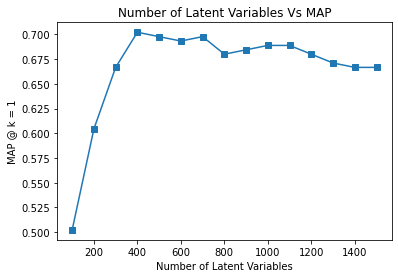

In [11]:
from tqdm import tqdm
components_used = [i*100 for i in range(1,16)]
Eval_inst = Evaluation()
MAP = []

for vals in tqdm(components_used):
        svd = TruncatedSVD(n_components=vals)
        svd.fit(tf_idf_docs_lsa.T)
        # transform the queries and document
        tr_docs_lsa = svd.transform(tf_idf_docs_lsa.T).T
        qr_tr_lsa = svd.transform(vec_rep_queries_lsa.T).T
        #_________________________________________________
        cosine_sim_lsa = np.matmul(tr_docs_lsa.T, qr_tr_lsa)
        # documents ranking for queries using lsa
        doc_IDs_ordered_lsa = (np.argsort(cosine_sim_lsa,axis=0)+1)[::-1].T.tolist()
        title = "LSA:- "+ str(vals) + " latent variables"
        Eval_metric(doc_IDs_ordered_lsa, query_ids, qrels,no_components=vals,plot_graph=0, title_name=title, verbose=0)
    # Storing all the MAP values for each n_comp
        MAP.append(Eval_inst.meanAveragePrecision(doc_IDs_ordered_lsa, query_ids, qrels, k =1))
    
#_________
#_____________
plt.plot(components_used, MAP,'-s')
# plt.scatter(components_used, MAP)
plt.title('Number of Latent Variables Vs MAP')
plt.xlabel('Number of Latent Variables')
plt.ylabel('MAP @ k = 1')
plt.show()

<u><b>Optimal LSA 

Precision, Recall, F-score, MAP, nDCG at 1 : 0.6933333333333334, 0.11552316963041481, 0.19057542084552576, 0.6933333333333334, 0.5185185185185185
_________________________________________________________________________________________________________________________________________________________
Precision, Recall, F-score, MAP, nDCG at 2 : 0.5844444444444444, 0.1902770450111435, 0.27029827118987027, 0.7422222222222222, 0.421676991375137
_________________________________________________________________________________________________________________________________________________________
Precision, Recall, F-score, MAP, nDCG at 3 : 0.5096296296296297, 0.2431851523847006, 0.3069069926148549, 0.7403703703703706, 0.3967626390129576
_________________________________________________________________________________________________________________________________________________________
Precision, Recall, F-score, MAP, nDCG at 4 : 0.46111111111111114, 0.28709537084138, 0.3274077637731295, 

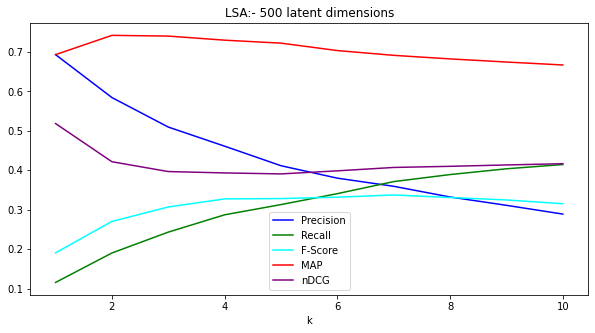

In [12]:
# best value, 500 latent dimensions as observed
vals = 500
title = "LSA:- "+ str(vals) + " latent dimensions"
svd = TruncatedSVD(n_components=vals)
svd.fit(tf_idf_docs_lsa.T)
tr_docs_lsa = svd.transform(tf_idf_docs_lsa.T).T
qr_tr_lsa = svd.transform(vec_rep_queries_lsa.T).T
cosine_sim_lsa = np.matmul(tr_docs_lsa.T, qr_tr_lsa)
doc_IDs_ordered_lsa = (np.argsort(cosine_sim_lsa,axis=0)+1)[::-1].T.tolist()
Eval_metric(doc_IDs_ordered_lsa, query_ids, qrels,no_components=vals,plot_graph=1, title_name=title)

<u><b>Observations

In [13]:
 query_precision_vector_space, query_recall_vector_space, query_fscore_vector_space, query_ndcg_vector_space = trial_run(qrels, doc_IDs_ordered_vector_space,queries, k = 7, model_name = 'Vector_Space')

In [14]:
 query_precision_lsa, query_recall_lsa, query_fscore_lsa, query_ndcg_lsa = trial_run(qrels, doc_IDs_ordered_lsa,queries, k = 7, model_name = 'LSA')

<u><b>Coparing VSM Vs LSA

    We will do hypothesis test

Two Sample t-test

Null Hypothesis : vector_space and LSA are performing same

Alternate Hypothesis : vector_space and LSA are not performing same

Results: p-value > 0.05, so we do not have enough evidence to reject the Null Hypothesis

In [15]:
import numpy as np
from scipy.special import stdtr

def hypo_testing(a, b):
    x = np.array(a)
    y = np.array(b)
    #____________________________
    x_mean = x.mean()
    x_var = x.var(ddof=1)
    x_size = x.size
    x_dof = x.size - 1
    #____________________________

    y_mean = y.mean()
    y_var = y.var(ddof=1)
    y_size = y.size
    y_dof = y.size - 1

    #Applying formula_____________________________________________
    t = (x_mean - y_mean) / np.sqrt(x_var/x_size+ y_var/y_size)
    dof = (x_var/x_size + y_var/y_size)**2 / (x_var**2/(x_size**2*x_dof) + y_var**2/(y_size**2*y_dof))
    p = 2*stdtr(dof, -np.abs(t))

    print("t value and p value: t = %g  p = %g" % (t, p))

In [16]:
# Hypothesis Testing VSM Vs LSA
print('Precision:-')
hypo_testing(query_precision_vector_space, query_precision_lsa)
#________________________________________________________________
print('Recall:-')
hypo_testing(query_recall_vector_space, query_recall_lsa)
#________________________________________________________________
print('F-Score:-')
hypo_testing(query_fscore_vector_space, query_fscore_lsa)

print('nDCG:-')
hypo_testing(query_ndcg_vector_space, query_ndcg_lsa)

Precision:-
t value and p value: t = -0.653615  p = 0.513695
Recall:-
t value and p value: t = -0.741645  p = 0.458691
F-Score:-
t value and p value: t = -0.7906  p = 0.429596
nDCG:-
t value and p value: t = -0.760771  p = 0.447194


<u><b> Query Expansion


 Distributional Word Similarity

In [17]:
import time
from gensim.models import Word2Vec
sentenceset = [sentence.split(" ") for sentence in corpus]
#_______________________using the pretained word embedding
model = Word2Vec(min_count=1,window = 3,vector_size = 500,sample = 6e-5)
initial = time.time()
model.build_vocab(sentenceset, progress_per = 1000)
final=time.time()
print('Time to build vocab:'+str((final - initial)/60)+' mins')

# training word embeddings on corpus_________________________________
initial = time.time()
model.train(sentenceset, total_examples=model.corpus_count, epochs=500, report_delay=1)
print('Time to train model:'+str((final - initial)/60)+' mins')

res = np.array(model.wv.most_similar(positive=["good"]))[:,0].tolist()[:10]
res

Time to build vocab:0.013388649622599284 mins
Time to train model:-1.3566017150878906e-05 mins


['agreement',
 'fair',
 'results',
 'for',
 'obtained',
 '',
 '.',
 'experimental',
 'excellent',
 'better']

<u><b> Query Expansion

In [18]:
def query_expansion(query, model,v=1):
    query_expand = []
    for sentence in query:
        for word in sentence:
            try:
                query_expand+=(np.array(model.wv.most_similar(positive=[word],topn = v))[:,0].tolist())
            except:
                pass
    return " ".join(query_expand)
dataframe_query['expanded_query'] = dataframe_query['query'].apply(lambda x: query_expansion([x.split(" ")], model))
dataframe_query['expanded_query'] += dataframe_query['query']
dataframe_query.head()

,query,expanded_query
0,what similarity laws must be obeyed when const...,how parameter /similarity lift-producing is (s...
1,what are the structural and aeroelastic proble...,"how is matric the estimations, equations acco..."
2,what problems of heat conduction in composite ...,how equations the transfer four-pole slab com...
3,can a criterion be developed to show empirical...,be the rayleigh-tollmien is method the indicat...
4,what chemical kinetic system is applicable to ...,how equilibria dilute solid-fuel the applied t...


### 4.3 TFIDF Representation

In [19]:
vectorizer = TfidfVectorizer()

corpus_queryexpanse = dataframe_docs['body'].tolist() + dataframe_query['expanded_query'].tolist()
X = vectorizer.fit_transform(corpus_queryexpanse)
print("Total number of docs and queries included are {} and Vocabulary size is {}".format(X.shape[0],X.shape[1]))

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tfidf_df.head()

Total number of docs and queries included are 1625 and Vocabulary size is 7466


,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000degree,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
tf_idf_docs_queryexpanse = tfidf_df[columns[:len(dataframe_docs)]].values
vec_rep_queries_queryexpanse = tfidf_df[columns[len(dataframe_docs):]].values
#= vectorizer.transform(dataframe_query["expanded_query"].tolist()).T.todense()

### 4.4 Ranking and Evaluation

Precision, Recall, F-score, MAP, nDCG at 1 : 0.5777777777777777, 0.09934555095279621, 0.16250893975943684, 0.5777777777777777, 0.4133333333333334
_________________________________________________________________________________________________________________________________________________________
Precision, Recall, F-score, MAP, nDCG at 2 : 0.4822222222222222, 0.15830540553950406, 0.22381150444393905, 0.6288888888888889, 0.34330901153545357
_________________________________________________________________________________________________________________________________________________________
Precision, Recall, F-score, MAP, nDCG at 3 : 0.4177777777777779, 0.1979708068049052, 0.24998199068246357, 0.6262962962962965, 0.32861278614150935
_________________________________________________________________________________________________________________________________________________________
Precision, Recall, F-score, MAP, nDCG at 4 : 0.37222222222222223, 0.2294433283905545, 0.26291626147

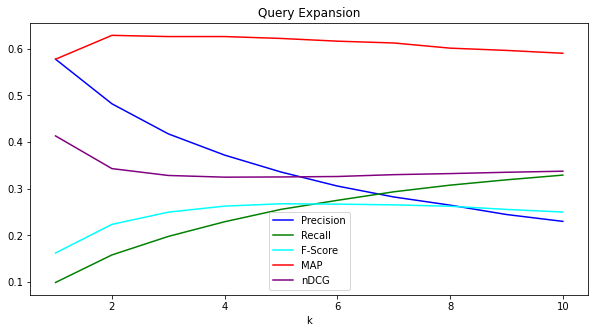

In [21]:
cosine_sim_queryexpanse = np.matmul(tf_idf_docs_queryexpanse.T, vec_rep_queries_queryexpanse)
doc_IDs_ordered_queryexpanse = (np.argsort(cosine_sim_queryexpanse,axis=0)+1)[::-1].T.tolist()
Eval_metric(doc_IDs_ordered_queryexpanse, query_ids, qrels,no_components=0,plot_graph=1,title_name="Query Expansion")

<u><b> Query Expansion(queryexpanse) Vs LSA



Query expanse performs worse compared to LSA. Word2vec improves if trained on large corpus.

In [22]:
 query_precision_queryexpanse, query_recall_queryexpanse, query_fscore_queryexpanse, query_ndcg_queryexpanse = trial_run(qrels, doc_IDs_ordered_queryexpanse,queries, k = 7, model_name = 'Vector_Space')

In [23]:
# Hypothesis Testing queryexpanse Vs LSA
print('Precision:-')
hypo_testing(query_precision_queryexpanse, query_precision_lsa)
#________________________________________________________________
print('Recall:-')
hypo_testing(query_recall_queryexpanse, query_recall_lsa)
#________________________________________________________________
print('F-Score:-')
hypo_testing(query_fscore_queryexpanse, query_fscore_lsa)
#________________________________________________________________
print('nDCG:-')
hypo_testing(query_ndcg_queryexpanse, query_ndcg_lsa)

Precision:-
t value and p value: t = -3.49528  p = 0.000520868
Recall:-
t value and p value: t = -3.10983  p = 0.00199194
F-Score:-
t value and p value: t = -3.62607  p = 0.000320884
nDCG:-
t value and p value: t = -3.26275  p = 0.0011879


Examples where VSM recall was less than query expanse model

In [24]:
import random
df = pd.DataFrame(qrels)
itera=0
while itera<=10:
    index=int(random.random()*100)
    if   query_recall_vector_space[index]< query_recall_queryexpanse[index]:
        print("Expanded Query : ", dataframe_query['expanded_query'][index])
        print("Initial Query : ", dataframe_query['query'][index])
        print("VSM Recall : ", query_recall_vector_space[index])
        print("queryexpanse Recall : ", query_recall_queryexpanse[index])
        itera+=1
        print('_________')

Expanded Query :  the the necessary the investigate rate the convective, i-beam transfer heat the aerodynamically shells the cross-section, non-circular the no-slip flow the is velocity  cross-section, is it possible to determine rates of forced convective heat transfer from heated cylinders of non-circular cross-section,  (the fluid flow being along the generators) .
Initial Query :  is it possible to determine rates of forced convective heat transfer from heated cylinders of non-circular cross-section,  (the fluid flow being along the generators) .
VSM Recall :  0.2
queryexpanse Recall :  0.3
_________
Expanded Query :  ablating parameters the paraplex /tailoring/ material properties of photoelastic materials .
Initial Query :  material properties of photoelastic materials .
VSM Recall :  0.3333333333333333
queryexpanse Recall :  0.6666666666666666
_________
Expanded Query :  ablating parameters the paraplex /tailoring/ material properties of photoelastic materials .
Initial Query : 

##  KMeans Clustering


 Tuning for number of Clusters

In [25]:
for i in range(len(tf_idf_docs_lsa)):
    if sum(tf_idf_docs_lsa[i])>1:
        print(tf_idf_docs_lsa[i],i)

[0. 0. 0. ... 0. 0. 0.] 1
[0. 0. 0. ... 0. 0. 0.] 34
[0. 0. 0. ... 0. 0. 0.] 35
[0. 0. 0. ... 0. 0. 0.] 46
[0. 0. 0. ... 0. 0. 0.] 55
[0.         0.         0.         ... 0.         0.15505126 0.        ] 62
[0. 0. 0. ... 0. 0. 0.] 65
[0. 0. 0. ... 0. 0. 0.] 74
[0. 0. 0. ... 0. 0. 0.] 81
[0. 0. 0. ... 0. 0. 0.] 86
[0. 0. 0. ... 0. 0. 0.] 87
[0. 0. 0. ... 0. 0. 0.] 133
[0. 0. 0. ... 0. 0. 0.] 162
[0. 0. 0. ... 0. 0. 0.] 169
[0. 0. 0. ... 0. 0. 0.] 180
[0. 0. 0. ... 0. 0. 0.] 202
[0. 0. 0. ... 0. 0. 0.] 220
[0. 0. 0. ... 0. 0. 0.] 235
[0. 0. 0. ... 0. 0. 0.] 251
[0. 0. 0. ... 0. 0. 0.] 252
[0. 0. 0. ... 0. 0. 0.] 282
[0. 0. 0. ... 0. 0. 0.] 298
[0. 0. 0. ... 0. 0. 0.] 314
[0. 0. 0. ... 0. 0. 0.] 331
[0. 0. 0. ... 0. 0. 0.] 355
[0. 0. 0. ... 0. 0. 0.] 369
[0. 0. 0. ... 0. 0. 0.] 399
[0. 0. 0. ... 0. 0. 0.] 402
[0. 0. 0. ... 0. 0. 0.] 403
[0. 0. 0. ... 0. 0. 0.] 408
[0. 0. 0. ... 0. 0. 0.] 418
[0. 0. 0. ... 0. 0. 0.] 442
[0. 0. 0. ... 0. 0. 0.] 444
[0. 0. 0. ... 0. 0. 0.] 454
[0. 0. 0. ..

[0. 0. 0. ... 0. 0. 0.] 1331
[0. 0. 0. ... 0. 0. 0.] 1345
[0. 0. 0. ... 0. 0. 0.] 1352
[0. 0. 0. ... 0. 0. 0.] 1354
[0. 0. 0. ... 0. 0. 0.] 1355
[0. 0. 0. ... 0. 0. 0.] 1361
[0. 0. 0. ... 0. 0. 0.] 1365
[0. 0. 0. ... 0. 0. 0.] 1368
[0. 0. 0. ... 0. 0. 0.] 1377
[0. 0. 0. ... 0. 0. 0.] 1383
[0.         0.07384879 0.         ... 0.         0.         0.        ] 1387
[0. 0. 0. ... 0. 0. 0.] 1399
[0. 0. 0. ... 0. 0. 0.] 1402
[0. 0. 0. ... 0. 0. 0.] 1403
[0. 0. 0. ... 0. 0. 0.] 1404
[0. 0. 0. ... 0. 0. 0.] 1414
[0. 0. 0. ... 0. 0. 0.] 1422
[0. 0. 0. ... 0. 0. 0.] 1423
[0. 0. 0. ... 0. 0. 0.] 1429
[0. 0. 0. ... 0. 0. 0.] 1435
[0. 0. 0. ... 0. 0. 0.] 1446
[0. 0. 0. ... 0. 0. 0.] 1447
[0. 0. 0. ... 0. 0. 0.] 1448
[0. 0. 0. ... 0. 0. 0.] 1449
[0. 0. 0. ... 0. 0. 0.] 1450
[0. 0. 0. ... 0. 0. 0.] 1454
[0. 0. 0. ... 0. 0. 0.] 1466
[0. 0. 0. ... 0. 0. 0.] 1472
[0. 0. 0. ... 0. 0. 0.] 1475
[0. 0. 0. ... 0. 0. 0.] 1476
[0. 0. 0. ... 0. 0. 0.] 1478
[0. 0. 0. ... 0. 0. 0.] 1479
[0. 0. 0. ... 0. 0. 0.] 

[0. 0. 0. ... 0. 0. 0.] 2264
[0. 0. 0. ... 0. 0. 0.] 2273
[0. 0. 0. ... 0. 0. 0.] 2274
[0. 0. 0. ... 0. 0. 0.] 2277
[0. 0. 0. ... 0. 0. 0.] 2280
[0.         0.         0.         ... 0.         0.16293327 0.        ] 2288
[0. 0. 0. ... 0. 0. 0.] 2312
[0.11360191 0.         0.         ... 0.         0.         0.        ] 2316
[0. 0. 0. ... 0. 0. 0.] 2322
[0. 0. 0. ... 0. 0. 0.] 2327
[0. 0. 0. ... 0. 0. 0.] 2328
[0. 0. 0. ... 0. 0. 0.] 2331
[0. 0. 0. ... 0. 0. 0.] 2334
[0. 0. 0. ... 0. 0. 0.] 2335
[0. 0. 0. ... 0. 0. 0.] 2337
[0. 0. 0. ... 0. 0. 0.] 2341
[0. 0. 0. ... 0. 0. 0.] 2344
[0. 0. 0. ... 0. 0. 0.] 2352
[0.         0.05234097 0.         ... 0.07912061 0.         0.        ] 2354
[0.         0.         0.         ... 0.0496928  0.12015407 0.        ] 2356
[0.04540402 0.         0.         ... 0.         0.         0.05212509] 2362
[0. 0. 0. ... 0. 0. 0.] 2364
[0. 0. 0. ... 0. 0. 0.] 2366
[0.0426116  0.04049506 0.         ... 0.         0.         0.        ] 2367
[0. 0. 0. ... 0.

[0.         0.         0.         ... 0.         0.         0.11872618] 3156
[0. 0. 0. ... 0. 0. 0.] 3157
[0. 0. 0. ... 0. 0. 0.] 3159
[0. 0. 0. ... 0. 0. 0.] 3165
[0. 0. 0. ... 0. 0. 0.] 3167
[0. 0. 0. ... 0. 0. 0.] 3168
[0. 0. 0. ... 0. 0. 0.] 3169
[0. 0. 0. ... 0. 0. 0.] 3170
[0. 0. 0. ... 0. 0. 0.] 3177
[0. 0. 0. ... 0. 0. 0.] 3179
[0. 0. 0. ... 0. 0. 0.] 3186
[0. 0. 0. ... 0. 0. 0.] 3191
[0. 0. 0. ... 0. 0. 0.] 3196
[0. 0. 0. ... 0. 0. 0.] 3207
[0. 0. 0. ... 0. 0. 0.] 3209
[0. 0. 0. ... 0. 0. 0.] 3219
[0. 0. 0. ... 0. 0. 0.] 3236
[0.        0.0390422 0.        ... 0.        0.        0.       ] 3241
[0.         0.04219687 0.         ... 0.         0.         0.        ] 3245
[0. 0. 0. ... 0. 0. 0.] 3248
[0. 0. 0. ... 0. 0. 0.] 3252
[0. 0. 0. ... 0. 0. 0.] 3253
[0. 0. 0. ... 0. 0. 0.] 3259
[0. 0. 0. ... 0. 0. 0.] 3260
[0. 0. 0. ... 0. 0. 0.] 3262
[0. 0. 0. ... 0. 0. 0.] 3263
[0. 0. 0. ... 0. 0. 0.] 3267
[0. 0. 0. ... 0. 0. 0.] 3272
[0. 0. 0. ... 0. 0. 0.] 3276
[0. 0. 0. ... 0. 0. 0

[0. 0. 0. ... 0. 0. 0.] 4147
[0. 0. 0. ... 0. 0. 0.] 4148
[0. 0. 0. ... 0. 0. 0.] 4150
[0. 0. 0. ... 0. 0. 0.] 4155
[0. 0. 0. ... 0. 0. 0.] 4157
[0. 0. 0. ... 0. 0. 0.] 4158
[0. 0. 0. ... 0. 0. 0.] 4159
[0. 0. 0. ... 0. 0. 0.] 4169
[0. 0. 0. ... 0. 0. 0.] 4176
[0. 0. 0. ... 0. 0. 0.] 4195
[0. 0. 0. ... 0. 0. 0.] 4203
[0. 0. 0. ... 0. 0. 0.] 4204
[0. 0. 0. ... 0. 0. 0.] 4206
[0. 0. 0. ... 0. 0. 0.] 4208
[0. 0. 0. ... 0. 0. 0.] 4215
[0. 0. 0. ... 0. 0. 0.] 4221
[0. 0. 0. ... 0. 0. 0.] 4225
[0. 0. 0. ... 0. 0. 0.] 4230
[0. 0. 0. ... 0. 0. 0.] 4232
[0. 0. 0. ... 0. 0. 0.] 4235
[0. 0. 0. ... 0. 0. 0.] 4236
[0. 0. 0. ... 0. 0. 0.] 4237
[0. 0. 0. ... 0. 0. 0.] 4238
[0. 0. 0. ... 0. 0. 0.] 4242
[0. 0. 0. ... 0. 0. 0.] 4243
[0. 0. 0. ... 0. 0. 0.] 4244
[0. 0. 0. ... 0. 0. 0.] 4249
[0. 0. 0. ... 0. 0. 0.] 4259
[0. 0. 0. ... 0. 0. 0.] 4262
[0. 0. 0. ... 0. 0. 0.] 4267
[0. 0. 0. ... 0. 0. 0.] 4277
[0. 0. 0. ... 0. 0. 0.] 4279
[0. 0. 0. ... 0. 0. 0.] 4292
[0. 0. 0. ... 0. 0. 0.] 4293
[0. 0. 0. ... 

[0. 0. 0. ... 0. 0. 0.] 5388
[0. 0. 0. ... 0. 0. 0.] 5389
[0. 0. 0. ... 0. 0. 0.] 5393
[0. 0. 0. ... 0. 0. 0.] 5395
[0. 0. 0. ... 0. 0. 0.] 5396
[0. 0. 0. ... 0. 0. 0.] 5403
[0. 0. 0. ... 0. 0. 0.] 5414
[0. 0. 0. ... 0. 0. 0.] 5421
[0. 0. 0. ... 0. 0. 0.] 5429
[0. 0. 0. ... 0. 0. 0.] 5430
[0. 0. 0. ... 0. 0. 0.] 5433
[0. 0. 0. ... 0. 0. 0.] 5436
[0. 0. 0. ... 0. 0. 0.] 5444
[0.         0.         0.         ... 0.         0.         0.05377425] 5448
[0. 0. 0. ... 0. 0. 0.] 5450
[0. 0. 0. ... 0. 0. 0.] 5451
[0. 0. 0. ... 0. 0. 0.] 5453
[0. 0. 0. ... 0. 0. 0.] 5455
[0. 0. 0. ... 0. 0. 0.] 5457
[0. 0. 0. ... 0. 0. 0.] 5458
[0. 0. 0. ... 0. 0. 0.] 5459
[0. 0. 0. ... 0. 0. 0.] 5460
[0. 0. 0. ... 0. 0. 0.] 5461
[0.06290021 0.         0.         ... 0.         0.         0.07221119] 5464
[0. 0. 0. ... 0. 0. 0.] 5466
[0. 0. 0. ... 0. 0. 0.] 5468
[0. 0. 0. ... 0. 0. 0.] 5469
[0. 0. 0. ... 0. 0. 0.] 5470
[0. 0. 0. ... 0. 0. 0.] 5474
[0. 0. 0. ... 0. 0. 0.] 5475
[0. 0. 0. ... 0. 0. 0.] 5481
[0. 0

[0. 0. 0. ... 0. 0. 0.] 6486
[0. 0. 0. ... 0. 0. 0.] 6493
[0. 0. 0. ... 0. 0. 0.] 6496
[0.09280333 0.         0.         ... 0.         0.         0.        ] 6498
[0. 0. 0. ... 0. 0. 0.] 6499
[0. 0. 0. ... 0. 0. 0.] 6515
[0.         0.05094473 0.         ... 0.         0.         0.        ] 6517
[0. 0. 0. ... 0. 0. 0.] 6519
[0. 0. 0. ... 0. 0. 0.] 6520
[0. 0. 0. ... 0. 0. 0.] 6524
[0. 0. 0. ... 0. 0. 0.] 6525
[0. 0. 0. ... 0. 0. 0.] 6528
[0. 0. 0. ... 0. 0. 0.] 6529
[0. 0. 0. ... 0. 0. 0.] 6534
[0. 0. 0. ... 0. 0. 0.] 6540
[0. 0. 0. ... 0. 0. 0.] 6543
[0. 0. 0. ... 0. 0. 0.] 6561
[0. 0. 0. ... 0. 0. 0.] 6571
[0.         0.         0.         ... 0.11106851 0.13427833 0.17752168] 6572
[0. 0. 0. ... 0. 0. 0.] 6582
[0. 0. 0. ... 0. 0. 0.] 6583
[0. 0. 0. ... 0. 0. 0.] 6590
[0. 0. 0. ... 0. 0. 0.] 6592
[0. 0. 0. ... 0. 0. 0.] 6601
[0. 0. 0. ... 0. 0. 0.] 6602
[0. 0. 0. ... 0. 0. 0.] 6604
[0. 0. 0. ... 0. 0. 0.] 6605
[0. 0. 0. ... 0. 0. 0.] 6611
[0. 0. 0. ... 0. 0. 0.] 6612
[0. 0. 0. ... 0

[0. 0. 0. ... 0. 0. 0.] 7455
[0. 0. 0. ... 0. 0. 0.] 7459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.67s/it]


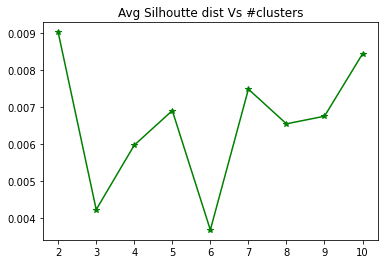

In [26]:
#____
dataframe_cluster = tf_idf_docs_lsa.T
silhout_scores = np.array([0.0 for i in range(2,11)])
# grid search, values 2-11
for i in tqdm(range(1)):
    for values in range(2,11):
        #_______________________________________
        clusterer = KMeans(n_clusters=values)
        preds = clusterer.fit_predict(dataframe_cluster)
        #Find centres___________________________
        centers = clusterer.cluster_centers_

        score = silhouette_score(dataframe_cluster, preds)
        silhout_scores[values-2]+=score
#         print("For # of clusters = "+str(values)+", silhouette score is "+str(score))
silhout_scores=silhout_scores/1

    
plt.plot(list(range(2,11)),silhout_scores, marker='*',color= 'green')
plt.title("Avg Silhoutte dist Vs #clusters")
plt.show()

Distortion_________________

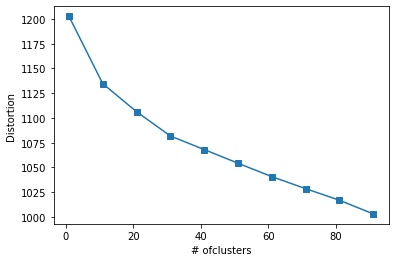

In [27]:
# calculate distortion for a range of number of cluster
distortionset = []
# Elbow plot to find the optimal clusters
for i in range(1, 100, 10):
    kmeans = KMeans(n_clusters=i, init='random',n_init=10, max_iter=400,tol=1e-03, random_state=0)
    kmeans.fit(tf_idf_docs_lsa.T)
    distortionset.append(kmeans.inertia_)
#___________________________________________________
plt.plot( list(range(1,100,10)), distortionset, marker='s')
plt.xlabel('# ofclusters')
plt.ylabel('Distortion ')
plt.show()

<u><b>Optimal number of clusters
    
    At large values, trade-off for precision, recall, other metrics score is huge and retrieval time for n=6 and n=9 is very similar. So we choose number of cluster, n = 6 as optimal number of clusters

In [28]:

corpus = dataframe_docs['body'].tolist() + dataframe_query['query'].tolist()
vectorizer = TfidfVectorizer()
alpa = vectorizer.fit_transform(corpus)
#___________________________________________________________________________
feature_names = vectorizer.get_feature_names()
clms = ['doc_' + str(i) for i in range(1,alpa.shape[0]+1)]
#___________________________________________________________________________
tfidf_df = pd.DataFrame(alpa.T.todense(), index=feature_names, columns=clms)
tf_idf_docs_km= tfidf_df[columns[:len(dataframe_docs)]].values 
vec_rep_queries_km= tfidf_df[columns[len(dataframe_docs):]].values 

In [29]:
# Best # of clusters = 6
kmeans = KMeans(n_clusters= 6, random_state=0)
kmeans.fit(tf_idf_docs_km.T)

KMeans(n_clusters=6, random_state=0)

In [30]:
cluster_doc_ids = {}
#________________________
for i in range(1400):
    try:
        cluster_doc_ids[kmeans.labels_[i]] += [i]
    except :
        cluster_doc_ids[kmeans.labels_[i]] = [i]

In [31]:
# cluster_doc_ids[37]

<u><b>hypothesis testing

In [32]:
#______________________
no_clust = []
for j in range(200):
    initial = time.time()
    cosine_sim = []
    for i in range(1400):
        cosine_sim.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    #________________________________
    cosine_sim = np.array(cosine_sim)
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
    final = time.time()
    no_clust.append((final-initial))

clust = []
for j in range(200):
        initial = time.time()
        cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, kmeans.cluster_centers_.T))
        cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
        cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
        doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
        doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clus]+1
        final = time.time()
        clust.append((final-initial))


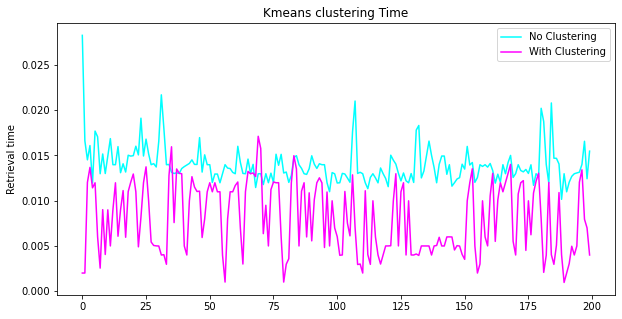

In [33]:
# plot
plt.figure(figsize = (10,5))
plt.title('Kmeans clustering Time')
plt.plot(range(200), no_clust, label = 'No Clustering',color='cyan')
plt.plot(range(200), clust, label = 'With Clustering',color='magenta')
plt.ylabel('Retrieval time')
plt.legend()
plt.show()

In [34]:
# hypothesis testing
hypo_testing(no_clust, clust)

t value and p value: t = 19.192  p = 1.88952e-54


<u><B> LDA

In [35]:
countvec = CountVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
dtm = countvec.fit_transform(dataframe_docs["body"])
#________LDA______________________________________________________
LDA = LatentDirichletAllocation(n_components=6, random_state = 42)
LDA.fit(dtm)
topic_results = LDA.transform(dtm)
dataframe_docs["LDA"] = topic_results.argmax(axis = 1)
dataframe_docs.head()

,body,LDA
0,experimental investigation of the aerodynamics...,3
1,simple shear flow past a flat plate in an inco...,4
2,the boundary layer in simple shear flow past a...,4
3,approximate solutions of the incompressible la...,4
4,one-dimensional transient heat conduction into...,5


### 6.2 Average Retrieval Time

In [36]:
#-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-assigning documents to a topic
cluster_doc_ids = {}
for i in range(1400):
    try :
        cluster_doc_ids[dataframe_docs["LDA"][i]] += [i]
    except :
        cluster_doc_ids[dataframe_docs["LDA"][i]] = [i]
        
cluster_centres = np.zeros((6,7464))
for i in range(6):
    cluster_centres[i,:] = np.mean(tf_idf_docs_km[:,cluster_doc_ids[i]], axis = 1)

In [37]:
# normal method of retrieval
no_clust_lda = []
clust_lda = []
init = time.time()
itera=224

for j in range(itera):
    cosine_sim = []
    initial=time.time()
    #__________________
    for i in range(1400):
        cosine_sim.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim = np.array(cosine_sim)
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
    final= time.time()
    no_clust_lda.append(final-initial)
    #___________________
fin = time.time()
#_________________

print("No clustering, Avg Retrieval time : "+str((fin-init)/itera))
print("________________________________________________________")
#___________________________________________________________________
init = time.time()
for j in range(itera):
    initial=time.time()
    #___________________
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, cluster_centres.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
    final=time.time()
    #____________________
    clust_lda.append(final-initial)
    
fin = time.time()
#______________________________________
print("clustering method, Retrieval time : "+str((fin-init)/itera))

No clustering, Avg Retrieval time : 0.012808743332113539
________________________________________________________
clustering method, Retrieval time : 0.007699815290314811


<u><b>Results and Observations
    
    Average retrieval time in case of clustering using Kmeans observed 50 - 70% decrease in the retrieval time.

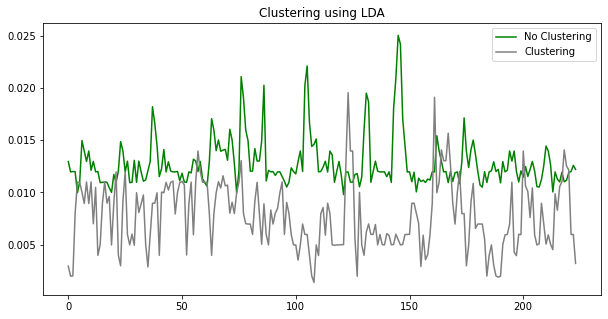

In [38]:
# plot
plt.figure(figsize = (10,5))
plt.title('Clustering using LDA')
plt.plot(range(224), no_clust_lda, label = 'No Clustering',color='green')
plt.plot(range(224), clust_lda, label = 'Clustering',color='gray')
plt.legend()
plt.show()